<h1><center> Stochastic Primal Dual Hybrid Gradient Algorithm: Tomography </center></h1>

 In this demo, we learn how to use the Stochastic Primal-Dual Hybrid (SPDHG) algorithm, see [here](https://arxiv.org/abs/1706.04957) and [here](https://arxiv.org/abs/1808.07150). This algorithm is a stochastic version of the Primal-Dual Hybrid Gradient (PDHG) Algorithm introduced by [Chambolle & Pock](https://hal.archives-ouvertes.fr/hal-00490826/document). We focus on Tomography Reconstruction under an edge-preserving prior, i.e., the __Total variation regularisation__, see [ROF](https://en.wikipedia.org/wiki/Total_variation_denoising). 

 ## Why SPDHG?

In the previous demo, we presented __PDHG__ for tomography reconstruction.

__SPDHG__ is a stochastic version of __PDHG__. As PDHG, SPDHG can solve convex, non necessarily smooth optimization problems and is provenly convergent. The central improvement with respect to PDHG is that SPDHG can deal with __subsets of data__, making it computationnally more efficient. 

For CT and PET for example, the data can be divided into a collection of partial sinograms, each of them corresponding to a subset of the total set of angles. Accordingly, the projection operator $A: X \rightarrow Y$ can be decomposed as $A=(A_1, \dots, A_n): X \rightarrow Y=Y_1\times \dots \times Y_n$ where $n$ is the number of subsets and each $A_i:X \rightarrow Y_i$ is a __partial__ projection.

At each iteration, SPDHG computes only one partial forward and back-projection $A_i,\,A_i^*$ for a randomly chosen index $i$, whereas PDHG computes $A$ and $A^*$. Hence SPDHG requires only a fraction of the computations of PDHG per iteration, which makes it faster.


## Learning objectives

1. Implement the subsetting
1. Implement default set-up
1. Compare PDHG and SPDHG: notion of epoch, visual comparison, measures (primal objective function and/or PSNR)
1. Tweak the default set-up: explicit / implicit, stepsizes


## Prerequisites

Pre-requisites:

1. ImageData, AcquisitionData, Blocks
1. Projection operator
1. Total Variation (TV)
1. PDHG implicit set-up for tomographic reconstruction. Optional: explicit set-up



## Tomography reconstruction

The minimisation problem for Total Variation Tomography reconstuction with TV is 

<a id='TomoTV'></a>
$$ \underset{u}{\operatorname{argmin}} \mathcal{O}(u)= \frac{1}{2} \| A u - g\|^{2} + \alpha\,\mathrm{TV}(u) +  \mathbb{I}_{\{u>0\}}(u) $$

where,

1. TV is defined as $$\mathrm{TV}(u) = \|\nabla u \|_{2,1} = \sum \sqrt{ (\partial_{y}u)^{2} + (\partial_{x}u)^{2} }$$
1. g is the Acqusisition data obtained from the detector.
1. $A$ is the projection operator ( _Radon transform_ ) that maps from an image-space to an acquisition space, i.e., $A : X \rightarrow Y, $ where X is an __ImageGeometry__ and Y is a __BlockDataContainer__ of __AcquisitionGeometry__ objects.
1. $\alpha$ is a regularising parameter that measures a trade-off between the fidelity and the regulariser terms.
1. The functional $\mathbb{I}_{\{u>0\}}(u) : = 
\begin{cases}
0, & \mbox{ if } u>0\\
\infty , & \mbox{ otherwise}
\quad
\end{cases}
$, $\quad$ is a positivity constraint for the minimiser $u$.


In order to use the SPDHG algorithm for the problem above, we need to express our minimisation problem into the following form:

<a id='SPDHG_form'></a>
$$\min_{u} \sum_{i=1}^n F_i(K_i u) + G(u)$$

where we assume that:

1. $F_i$, $G$ are __convex__ functionals
    
    - $F_i: Y_i \rightarrow \mathbb{R}$ 
    
    - $G: X \rightarrow \mathbb{R}$
    
    
2. $K_i$ is a continuous linear operator acting from a space X to another space Y_i :

$$K_i : X \rightarrow Y_i \quad $$ 

with operator norm  defined as $$\| K_i \| = \max\{ \|K_i x\|_{Y} : \|x\|_{X}\leq 1 \}.$$  

**Note**: We use the [Power Method](https://en.wikipedia.org/wiki/Power_iteration) to approximate the norm of the $K_i$'s and if needed of $\nabla$.

In [21]:
# Import libraries
 
from cil.framework import ImageData, ImageGeometry, AcquisitionGeometry, AcquisitionData, BlockDataContainer
 
from cil.optimisation.algorithms import PDHG, SPDHG
from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.optimisation.functions import IndicatorBox, BlockFunction, L2NormSquared, MixedL21Norm
 
from cil.io import TXRMDataReader
 
from cil.processors import Slicer, Binner, TransmissionAbsorptionConverter
 
from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.ccpi_regularisation.functions import FGP_TV
 
from cil.utilities.display import show2D
from cil.utilities.jupyter import islicer
 
#from utilities import read_frames, read_extra_frames, download_zenodo
 
import numpy as np
import matplotlib.pyplot as plt

Now, we would like to setup and run SPDHG algorithm for the above minimisation problem. 

First, we'll load the **walnut** dataset found in [Jørgensen_et_all](https://zenodo.org/record/4822516#.YLXyAJMzZp8) and work on the central slice only in the following demonstration. See more details in the PDHG notebook.

In [8]:
reader = TXRMDataReader()
filename = os.path.abspath('/home/cd902/valnut/valnut_tomo-A.txrm')

reader.set_up(file_name=filename, angle_unit='radian')
data3D = reader.read()

# reorder data to match default order for Astra/Tigre operator
# data3D.reorder(['vertical','angle','horizontal'])
data3D.reorder('astra')

# Get Image and Acquisition geometries
ag3D = data3D.geometry
# ag3D.config.angles.angle_data = -ag3D.config.angles.angle_data
ig3D = ag3D.get_ImageGeometry()

# Extract vertical slice
data2D = data3D.subset(vertical='centre')

# Select every 10 angles
sliced_data = Slicer(roi={'angle':(0,1601,10)})(data2D)

# Reduce background regions
binned_data = Binner(roi={'horizontal':(120,-120,2)})(sliced_data)

# Create absorption data 
data = TransmissionAbsorptionConverter()(binned_data) 

# Remove circular artifacts
data -= np.mean(data.as_array()[80:100,0:30])

# Get Image and Acquisition geometries for one slice
ag2D = data.geometry
ag2D.set_angles(ag2D.angles, initial_angle=0.2, angle_unit='radian')
ig2D = ag2D.get_ImageGeometry()

A = ProjectionOperator(ig2D, ag2D, device = "gpu")

AcquisitionGeometry configured using deprecated method


## How to setup and run SPDHG

In order to setup and run SPDHG, we need to define the following:

- The operator $K=(K_1,\dots,K_n)$.
- The functions $F=(F_1,\dots,F_N)$ and $G$.
- The maximum number of iterations

The setup and run of SPDHG:

` spdhg = SPDHG(f = F, g = G, operator = K, max_iteration = max_iteration)`

` spdhg.run()`

We can express our [problem](#TomoTV) into this [form](#SPDHG_form), if we let

1. $K = (A_1,\dots,A_n) \quad \Longleftrightarrow \quad $ `K = BlockOperator(A_i)`  

1. $F_i: Y_i \rightarrow \mathbb{R}, \mbox{ with } F_i(y_i) := \frac{1}{2}\| y_i - g_i \|^{2}, \quad \Longleftrightarrow \quad$ for all $i$'s, `F_i = 0.5 * L2NormSquared(data[i])` and  `F = BlockFunction(F_i)` 

1. $G: X \rightarrow \mathbb{R}, \mbox{ with } G(x) := \alpha\|\nabla x\|_{1} + \mathbb{I}_{\{x>0\}}(x), \quad \Longleftrightarrow \quad$ ` G = FGP_TV`.

### Define operator $K$, functions $F$  and $G$

In [16]:
# Define number of subsets
n_subsets = 10

# Divide the data into subsets
data_subsets = [Slicer(roi={'angle':(i,len(ag2D.angles),n_subsets)})(data) for i in range(n_subsets)]

# Form the list of $F_i$'s and $F$
f_subsets = [0.5*L2NormSquared(b = data_subsets[i]) for i in range(n_subsets)]
F = BlockFunction(*f_subsets)

# Form the list of $A_i$'s and $K$
geometries_subsets = [ag.geometry for ag in data_subsets ]
A_subsets = [ProjectionOperator(ig2D, ageom) for ageom in geometries_subsets]
K = BlockOperator(*A_subsets)

# Define G (by default the positivity constraint is on)
alpha = 0.01
G = alpha * FGP_TV()

### Setup and run SPDHG

__Note:__ in this example, there are some parameters which we don't pass, so that SPDHG will use default, pre-defined parameters. These parameters consist of:

1. The probabilities $p_i$ of choosing each subset $i$. By default these probabilities are uniform: if there are $n$ subsets, $p_i=1/n$. We'll see another choice in the part about *explicit set-up*.
1. The step-sizes of the algorithm. To know more about step-sizes setting, refer to the last part of the tutorial.

In [17]:
# Setup and run SPDHG for 50 iterations
spdhg = SPDHG(f = F, g = G, operator = K,  max_iteration = 50,
            update_objective_interval = 100)
spdhg.run()

spdhg_recon = spdhg.get_output()     

SPDHG setting up
SPDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0         50         0.000          6.90194e+03
-------------------------------------------------------
       50         50         0.067                     
Stop criterion has been reached.



### Show reconstruction result

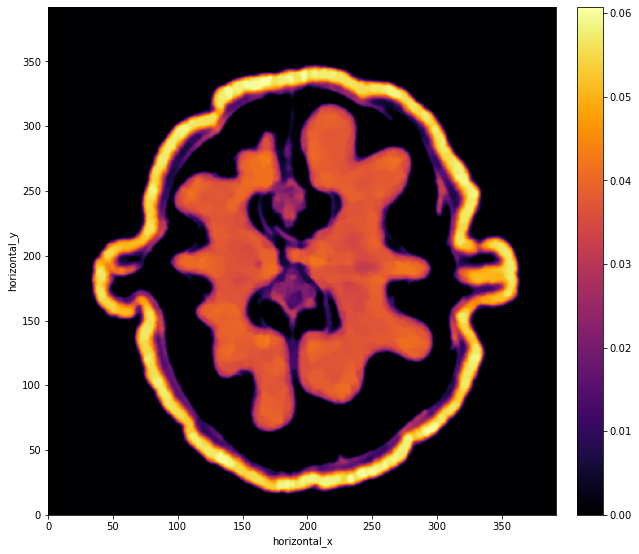

In [18]:
show2D(spdhg_recon, cmap='inferno')

## Comparison to PDHG

PDHG and SPDHG converge to the same set of solutions, but SPDHG is faster. How can we compare PDHG and SPDHG? We want to compare PDHG and SPDHG **for the same amount of computational effort**. Remember that at each iteration, PDHG computes one entire forward and back-projection, while SPDHG computes only a partial one. For example, if we have 10 subsets, $10$ iterations of SPDHG have the same computational cost than one iteration of PDHG. In order to have a fair comparison between both algorithms, we then define the notion of **epoch**, where one epoch corresponds to a full forward and back-projection. Hence, one epoch of PDHG corresponds to one iteration, while one epoch of SPDHG corresponds in our case to $10$ iteration.

Let's set-up and run PDHG and SPDHG for the same number of epochs and compare the results.



PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        500         0.000          6.90194e+03
        1        500         0.316          6.90194e+03
        2        500         0.268          6.73800e+02
        3        500         0.259          3.79485e+02
        4        500         0.253          2.21379e+02
        5        500         0.249          1.68951e+02
-------------------------------------------------------
        5        500         0.249          1.68951e+02
Stop criterion has been reached.

SPDHG setting up
SPDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       5000         0.000          6.90194e+03
       10       5000         0.082          1.65999e+02
       20       5000         0.071          5.78822e+01
       30       5000         0.066          4.34431e+01
    

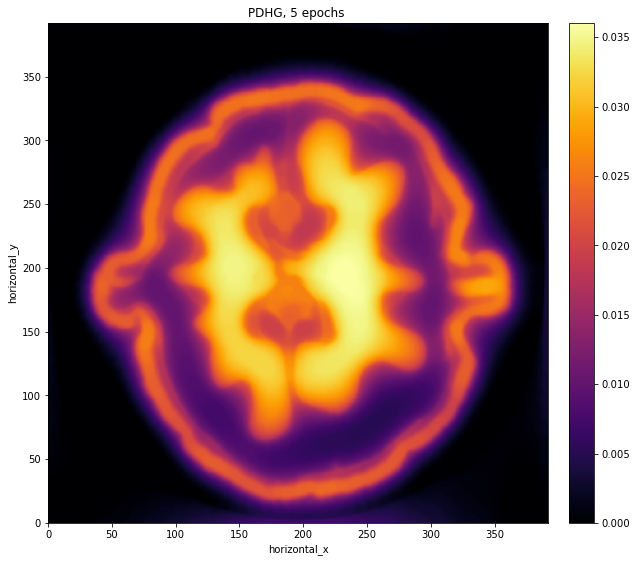

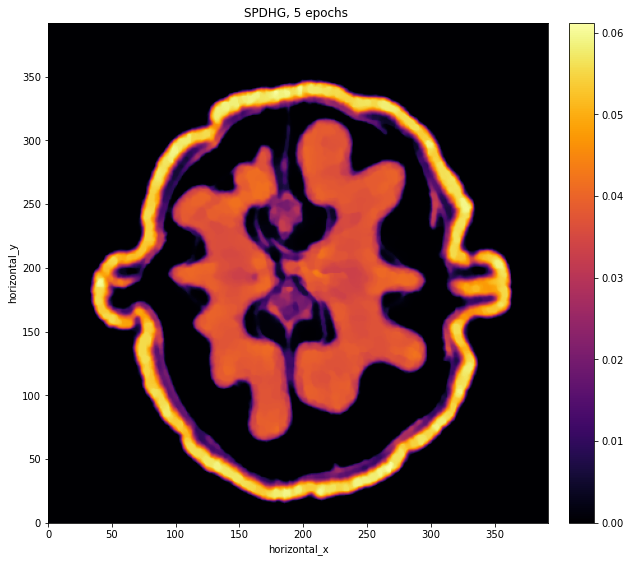

In [19]:
n_epoch = 5

# Setup and run PDHG
normK = K.norm()
tau = 1/normK
sigma = 1/normK
pdhg = PDHG(f = F, g = G, operator = K,  max_iteration = 500,
            update_objective_interval = 1, tau=tau, sigma=sigma)
pdhg.run(n_epoch)

pdhg_recon = pdhg.get_output() 

# Setup and run SPDHG
spdhg = SPDHG(f = F, g = G, operator = K,  max_iteration = 500 * n_subsets,
            update_objective_interval = 1 * n_subsets)
spdhg.run(n_epoch * n_subsets)

spdhg_recon = spdhg.get_output() 

show2D(pdhg_recon, cmap='inferno', title = "PDHG, {} epochs ".format(n_epoch))
show2D(spdhg_recon, cmap='inferno', title = "SPDHG, {} epochs ".format(n_epoch))

After 5 epochs, SPDHG reconstruction seems visually more converged than PDHG reconstruction.

To further compare PDHG and SPDHG speeds, let's use a quantitative measure of convergence, which is given by the value of the objective function $\mathcal{O}(u)$.

In [20]:
nepoch = 20
pdhg.run(nepoch)
pdhg_measures = pdhg.objective

spdhg.run(nepoch*n_subsets)
spdhg_measures = spdhg.objective

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        5        500         0.249          1.68951e+02
        6        500         0.247          1.28651e+02
        7        500         0.259          8.23915e+01
        8        500         0.285          5.50208e+01
        9        500         0.279          4.63598e+01
       10        500         0.275          4.80513e+01
       11        500         0.270          5.18201e+01
       12        500         0.266          5.33784e+01
       13        500         0.263          5.19718e+01
       14        500         0.270          4.85936e+01
       15        500         0.272          4.46422e+01
       16        500         0.401          4.12815e+01
       17        500         0.392          3.90419e+01
       18        500         0.382          3.79064e+01
       19        500         0.373          3.74635e+01
       20        500         0.374          3.72

NameError: name 'plt' is not defined

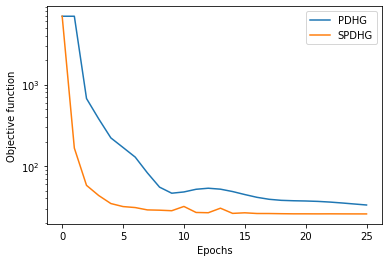

In [69]:
# plot 
epoch_range = np.arange(0,pdhg.iteration+pdhg.update_objective_interval, pdhg.update_objective_interval)
plt.semilogy(epoch_range, pdhg_measures, label='PDHG')
plt.semilogy(epoch_range, spdhg_measures, label='SPDHG')
plt.xlabel('Epochs')
plt.ylabel('Objective function')
plt.legend()

## Explicit set-up

As for PDHG, there are various ways to put our reconstruction [problem](#TomoTV):
$$ \underset{u}{\operatorname{argmin}} \mathcal{O}(u)= \frac{1}{2} \| A u - g\|^{2} + \alpha\,\mathrm{TV}(u) +  \mathbb{I}_{\{u>0\}}(u) $$
into SPDHG-appropriate [form](#SPDHG_form):
$$\min_{u} \sum_{i=1}^n F_i(K_i u) + G(u)$$. 

*Implicit set-up*

In the first part of the tutorial, we chose the so-called *implicit* set-up, where

1. $K = (A_1,\dots,A_n) \quad \Longleftrightarrow \quad $ `K = BlockOperator(A_i)`  

1. $F_i: Y_i \rightarrow \mathbb{R}, \mbox{ with } F_i(y_i) := \frac{1}{2}\| y_i - g_i \|^{2}, \quad \Longleftrightarrow \quad$ for all $i$'s, `F_i = 0.5 * L2NormSquared(data[i])` and  `F = BlockFunction(F_i)` 

1. $G: X \rightarrow \mathbb{R}, \mbox{ with } G(x) := \alpha\|\nabla x\|_{1} + \mathbb{I}_{\{x>0\}}(x), \quad \Longleftrightarrow \quad$ ` G = FGP_TV`.

*Explicit set-up*

As for PDHG, another way is to include the gradient of $\mathrm{TV}(u)=\|\nabla u\|_{1,2}$ into the operator $K$:

1. $K = (A_1,\dots,A_n, \nabla) \quad \Longleftrightarrow \quad $ `K = BlockOperator(A_1,...,A_n, Grad)`  

1. For all $1\leq i \leq n, F_i: Y_i \rightarrow \mathbb{R}, \mbox{ with } F_i(y_i) := \frac{1}{2}\| y_i - g_i \|^{2}$  and $F_{n+1}(z)=\|z\|_{1,2}$, $\quad \Longleftrightarrow \quad$ for all $1\leq i \leq n$, `F_i = 0.5 * L2NormSquared(data[i])`, `F_{n+1}=MixedL21Norm()` and  `F = BlockFunction(F_i)` 

1. $G: X \rightarrow \mathbb{R}, \mbox{ with } G(x) := \mathbb{I}_{\{x>0\}}(x), \quad \Longleftrightarrow \quad$ ` G = IndicatorBox(lower=0)`.

This time, we also use non-homogeneous probabilities: half of the time, we update the dual variable corresponding to TV, so that $p_{n+1}=1/2$, and half of the time we update one of the dual variable corresponding to one subset, so that $p_i=1/(2n)$ for $1\leq i \leq n$. 

__Comment:__ if you don't want to use the default homogeneous probabilites, the probabilities you specify need sum to $1$.



In [52]:
# Define number of subsets
n_subsets = 10

# Divide the data into subsets
data_subsets = [Slicer(roi={'angle':(i,len(ag2D.angles),n_subsets)})(data) for i in range(n_subsets)]

# Form the list of $F_i$'s and $F$
f_subsets = [0.5*L2NormSquared(b = data_subsets[i]) for i in range(n_subsets)]
# take into account the pixel size with ig2D.spacing
f_reg = ig2D.spacing[0] * alpha * MixedL21Norm()
F = BlockFunction(*f_subsets, f_reg)

# Form the list of $A_i$'s and $K$
geometries_subsets = [ag.geometry for ag in data_subsets ]
A_subsets = [ProjectionOperator(ig2D, ageom) for ageom in geometries_subsets]
Grad = GradientOperator(A_subsets[0].domain, backend='c', correlation='SpaceChannel')
K = BlockOperator(*A_subsets, Grad)

# Define G
G = IndicatorBox(lower=0)

# Define probabilities
prob = [1 / (2 * n_subsets)] * n_subsets + [1 / 2]

# Setup and run SPDHG for 50 iterations
spdhg_explicit = SPDHG(f = F, g = G, operator = K,  max_iteration = 50,
            update_objective_interval = 1 * n_subsets)
spdhg_explicit.run()

Initialised GradientOperator with C backend running with  8  threads
SPDHG setting up
SPDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0         50         0.000          6.90194e+03
       10         50         0.019          4.65153e+02
/home/cd902/miniconda3/envs/cil-school/lib/python3.8/site-packages/cil/framework/framework.py:2173: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )
       20         50         0.016          4.59719e+02
       30         50         0.015          1.75136e+02
       40         50         0.014          8.67388e+01
       50         50         0.014          5.53272e+01
-------------------------------------------------------
       50         50         0.014          5.53272e+01
Stop criterion has been reached.



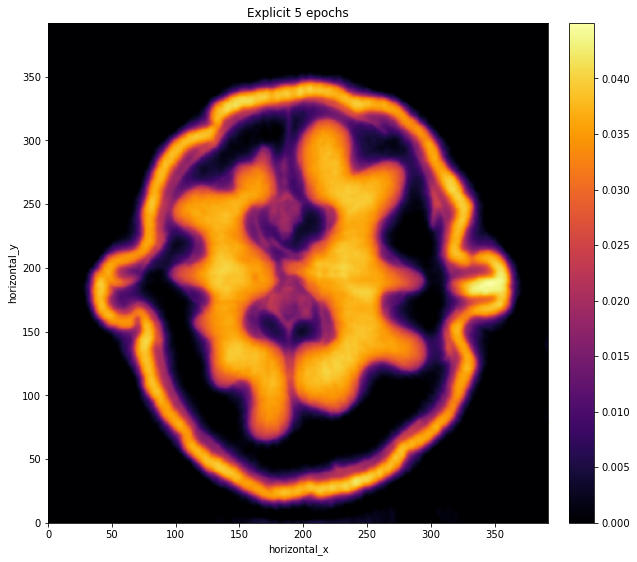

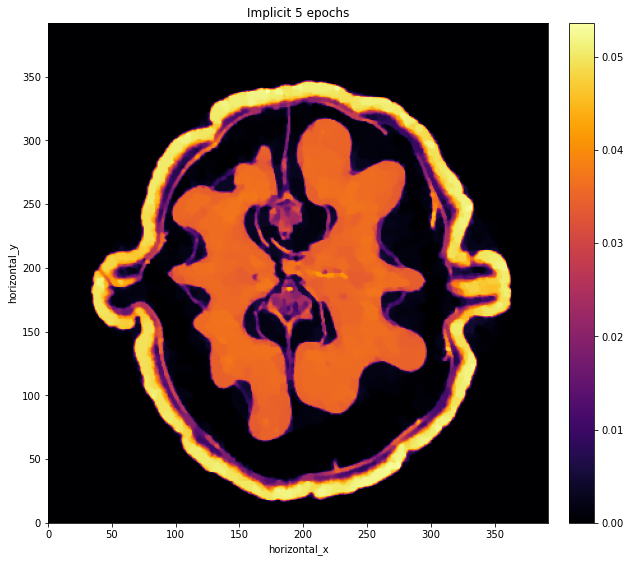

In [53]:
# Show result and compare to implicit framweork
spdhg_explicit_recon = spdhg_explicit.get_output()  
show2D(spdhg_explicit_recon, cmap='inferno', title= 'Explicit 5 epochs')
show2D(spdhg_recon, cmap='inferno', title= 'Implicit 5 epochs')

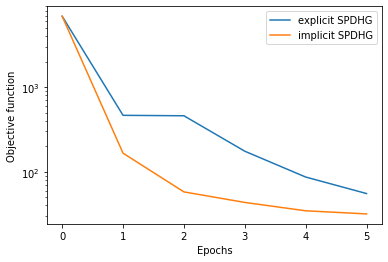

In [64]:
# Comparison of objective function
epoch_range = np.arange(0,6)
plt.semilogy(epoch_range, spdhg_explicit.objective, label='explicit SPDHG')
plt.semilogy(epoch_range, spdhg_measures[0:len(epoch_range)], label='implicit SPDHG')
plt.xlabel('Epochs')
plt.ylabel('Objective function')
plt.legend()

## Improve the speed of explicit reconstruction by re-normalizing

You can observe that the explicit reconstruction converges slower than the implicit one. However, the block operator $K$ used in the explicit framework is now formed by partial operators $A_{\text{subsets}}[i]$ and $\nabla$ with potentially very different norms. Empirically it hence makes sense to renormalize the partial operators so that they all have norm one. To leave the objective function unchanged, we'd also need to redefine the function $f_i$'s according to the following equations:
$$ \| K u - g\|_2^2 =  \|K\|^2 \cdot \left\| \frac{K}{\|K\|} u - \frac{g}{\|K\|}\right\|_2^2$$
$$ \| \nabla u\|_{1,2} =  \|\nabla \| \cdot \left\| \frac{\nabla}{\|\nabla\|} u\right\|_2$$

In [66]:
# Find the norm of each partial operator and renormalize
norms = [Ai.norm() for Ai in A_subsets]
Ks = [(1 / normi) * Ai for (normi, Ai) in zip(norms, A_subsets)]
fs = [0.5 * normi**2 * L2NormSquared(b = data_subsets[i]/normi) for i,normi in zip(range(n_subsets),norms)]

norms.append(Grad.norm())
Ks.append( (1 / norms[-1]) * Grad )
fs.append( norms[-1] * ig2D.spacing[0] * alpha * MixedL21Norm() )

# Form K and F
K = BlockOperator(*Ks)
F = BlockFunction(*fs)

# Setup and run SPDHG for 50 iterations
spdhg_explicit = SPDHG(f = F, g = G, operator = K,  max_iteration = 50,
            update_objective_interval = 1 * n_subsets)
spdhg_explicit.run()

SPDHG setting up
SPDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0         50         0.000          6.90194e+03
/home/cd902/miniconda3/envs/cil-school/lib/python3.8/site-packages/cil/framework/framework.py:2173: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )
       10         50         0.014          1.45773e+02
       20         50         0.014          4.96785e+01
       30         50         0.014          4.79666e+01
       40         50         0.014          4.00851e+01
       50         50         0.014          3.62314e+01
-------------------------------------------------------
       50         50         0.014          3.62314e+01
Stop criterion has been reached.



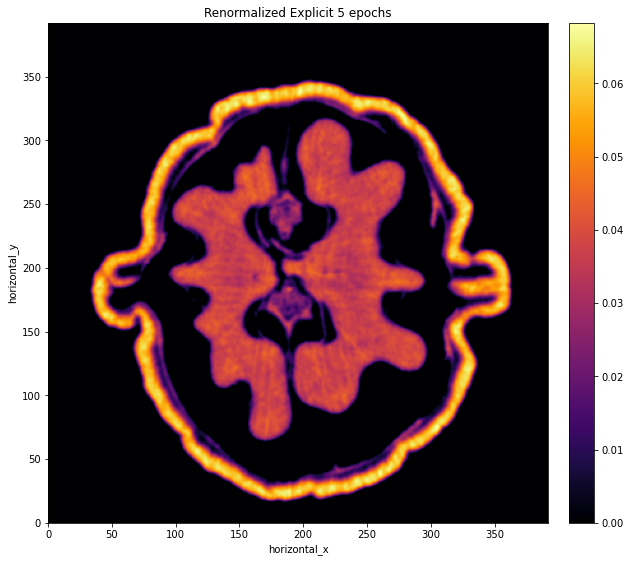

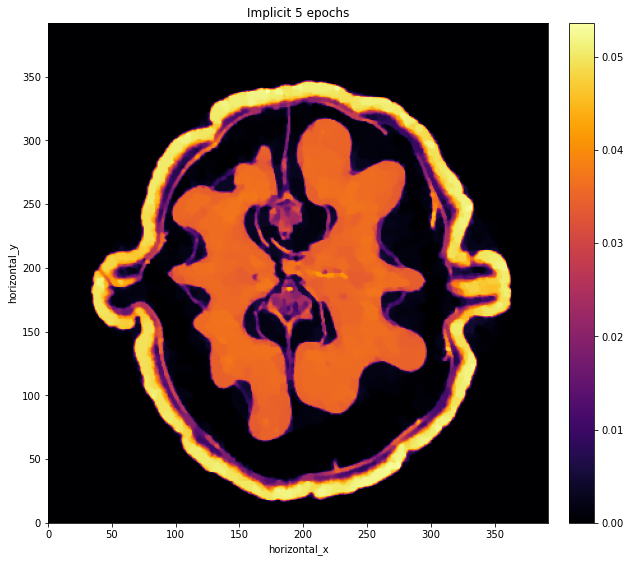

In [67]:
# Show result and compare to implicit framweork
spdhg_explicit_recon = spdhg_explicit.get_output()  
show2D(spdhg_explicit_recon, cmap='inferno', title= 'Renormalized Explicit 5 epochs')
show2D(spdhg_recon, cmap='inferno', title= 'Implicit 5 epochs')

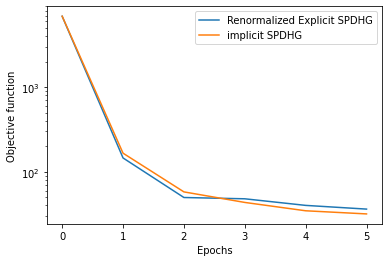

In [68]:
# Comparison of objective function
epoch_range = np.arange(0,6)
plt.semilogy(epoch_range, spdhg_explicit.objective, label='Renormalized Explicit SPDHG')
plt.semilogy(epoch_range, spdhg_measures[0:len(epoch_range)], label='implicit SPDHG')
plt.xlabel('Epochs')
plt.ylabel('Objective function')
plt.legend()

## When to use explicit or implicit framework?


1. Set-up: implicit framework is generally easier to set-up

1. Time-per-iteration: the time-per-iteration is greater in the implicit framework; indeed, at each iteration one needs to compute the proximal operator of the TV, which is done by in a (hidden) inner loop. This does not occur in the explicit framewro, where all the operators have explicit expressions (hence its name.)

1. Speed of convergence: there is no theoretical result as to which framework is the fastest. In the example above, one can observe that renormalized explicit SPDHG seems to converge at roughly the same speed than implicit SPDHG.


## Theoretical background

**Saddle-point formulation**


...to-do...

**Algorithm**

SPDHG is described as follows:

1. **Input:** Step-sizes $\tau, (\sigma_i)_{1\leq i \leq n}$, $\tau$; probabilities $p_i$ \\
1. **Initialize:** $x=0$, $y=0$, $z = \bar{z} = A^T y = 0$ \\
1. **Iterate** for $m=1, \dots$:

    1. Update primal variable: 
        $$x = \text{prox}_{\tau g}(x - \tau \bar{z}) $$
    1. Pick index $i$ at random with probability $p_i$
        $$ $$
    1. Update dual variable with index $i$: 
        $$ y_i^+ = \text{prox}_{\sigma_i f_i^*}(y_i + \sigma_i A_i x) $$
    1. Update secondary variables: 
        $$ d z = A_i^T(y_i^+ - y_i), \quad z = z + d z, \quad y_i = y_i^+ $$
    1. Perform extrapolation step:     
        $$ \bar{z}= z + (1/p_i) \cdot d z $$

**Admissible step-sizes**

SPDHG converges to the set of solutions of the saddle-point problem (in terms of Bregman distance [ref] and almost surely [ref1, ref2]) if the following conditions on step-sizes $\tau, (\sigma_i)_{1\leq i \leq n}$ is verified:
$$ \tau \, \sigma_i \, \|K_i\|^2 < p_i^2, \quad 1 \leq i \leq n$$

CIL default implementation is $\sigma_i = \rho/\|K_i\|$ for all $i$'s and $\tau =\rho\, \min_i p_i^2/\|K_i\|$ with $\rho=0.99$.


Other admissible choices would be $\sigma_i = \gamma \rho/\|K_i\|$ for all $i$'s and $\tau =\rho\, \min_i p_i^2/\|K_i\| / \gamma$ with $\rho=0.99$. Changing the value of $\gamma$ allows to change the balance between primal and dual convergence. It can be changed in the following way:

` spdhg = SPDHG(f = F, g = G, operator = K, max_iteration = max_iteration, gamma = gamma)`





